In [ ]:
# Lattice Boltzmann method code
# Poiseuille flow
import numpy as np

# Simulation parameters
nx = 100
ny = 50
niter = 1000
tau = 1
omega = 1/tau
cssq = 1/3 # speed of sound
nu = cssq*(tau - 0.5)

umax = 0.1

Re = umax*ny/nu # equation 7.6 in LB textbook
gradP = 8*nu*umax/ny**2 # equation above 5.30?

rhoout = 1
rhoin = 3*(nx - 1)*gradP + rhoout

# D2Q9 lattice arrangement
ndir = 9
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

# Simulation initialization
rho = np.ones((nx, ny))
ux = np.zeros((nx, ny))
uy = np.zeros((nx, ny))

feq = np.zeros((ndir, nx, ny))
for k in range(ndir):
    feq[k, :, :] = w[k]*rho
f = np.copy(feq)
fold = np.copy(feq)

# Simulation loop
for t in range(niter):

    # Collision
    f = (1 - omega)*fold + omega*feq

    # Boundary conditions
    # Inlet and outlet
    for k in range(ndir):
        f[k, 0, :] = w[k]*(rhoin + 3*(cx[k]*ux[nx - 2, :] + cy[k]*uy[nx - 2, :])) + (f[k, nx - 2, :] - feq[k, nx - 2, :])
        f[k, nx - 1, :] = w[k]*(rhoout + 3*(cx[k]*ux[1, :] + cy[k]*uy[1, :])) + (f[k, 1, :] - feq[k, 1, :])

    # Streaming - Explicit version
    for k in range(ndir):
        for i in range(nx):
            for j in range(ny):
                xstreamed = (i + cx[k] + nx)%nx
                ystreamed = (j + cy[k] + ny)%ny
                fold[k, xstreamed, ystreamed] = f[k, i, j]

    # Streaming - Using Python's np.roll
#    for k in range(ndir):
#        fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

    # Boundary conditions
    # No-slip boundary condition on the bottom and top walls (in the y-axis)
    # Implemented by half-way bounce-back
    fold[3, :, 0] = f[4, :, 0]
    fold[5, :, 0] = f[7, :, 0]
    fold[6, :, 0] = f[8, :, 0]

    fold[4, :, ny - 1] = f[3, :, ny - 1]
    fold[7, :, ny - 1] = f[5, :, ny - 1]
    fold[8, :, ny - 1] = f[6, :, ny - 1]

    # Macroscopic variables
    rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]
    ux = np.zeros((nx, ny))
    uy = np.zeros((nx, ny))
    for k in range(ndir):
        ux +=  cx[k]*fold[k, :, :]
        uy += cy[k]*fold[k, :, :]
    ux /= rho
    uy /= rho

    # Equilibrium distribution function
    for k in range(ndir):
        dotprod = cx[k]*ux + cy[k]*uy
        velmagn = ux**2 + uy**2
        feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*cssq**2) - velmagn/(2*cssq))


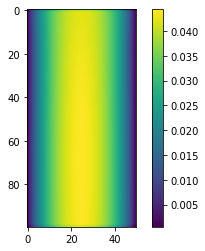

In [ ]:
# Post-processing
from matplotlib import pyplot as plt

umagn = np.sqrt(ux**2 + uy**2)
plt.imshow(umagn)
plt.colorbar()
plt.show()